### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

import automlx
from automlx import init

In [2]:
# Fetch example data set
dataset = fetch_openml(name='adult', as_frame=True)
df, y = dataset.data, dataset.target

In [3]:
# Output header data for quick inspection
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,2,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States
1,3,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States
2,2,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States
3,3,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States
4,1,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba


In [4]:
# Output default data types detected by the fetch (notice all are not correct, e.g., see "age" incorrectly listed as "category")
pd.DataFrame({'Data type': df.dtypes}).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
Data type,category,category,float64,category,float64,category,category,category,category,category,category,category,category,category


In [5]:
# Output % missing values per column
pd.DataFrame({'% missing vlaues': df.isnull().sum() * 100 / len(df)}).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
% missing vlaues,0.0,5.730724,0.0,0.0,0.0,0.0,5.751198,0.0,0.0,0.0,0.0,0.0,0.0,1.754637


[Text(0, 0, '37155'), Text(0, 0, '11687')]

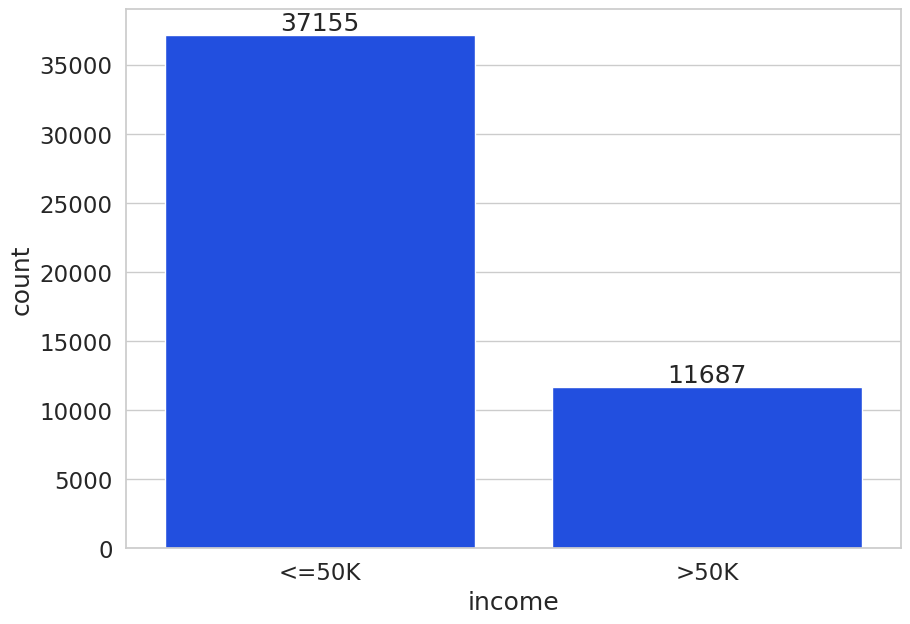

In [6]:
# visualize the distribution of the target variable (income)
y_df = pd.DataFrame(y)
y_df.columns = ['income']

ax = sns.countplot(x="income", data=y_df)
ax.bar_label(ax.containers[0])

In [7]:
# Correct the incorrect column data types
numeric_columns = ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
for col in df.columns:
    if col in numeric_columns:
        df[col] = df[col].astype(int)
        
        
# Split the data set into training and test data
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    y.map({'>50K': 1, '<=50K': 0}).astype(int),
                                                    train_size=0.7,
                                                    random_state=0)

# Output the shap of the training and test data sets
X_train.shape, X_test.shape

((34189, 14), (14653, 14))

In [8]:
# Initialize the AutoML Engine, setting it to use Python's parallelism library
init(engine='local')

In [9]:
# Create and fit a model using the AutoML Piepline (Preprocessing > Algorithm Selection > Adaptive Sampling > Feature Selection > Hyperparameter Tuning)
est1 = automlx.Pipeline(task='classification')
est1.fit(X_train, y_train)

[2025-10-28 12:53:34,886] [automlx.interface] Dataset shape: (34189,14)
[2025-10-28 12:53:35,000] [automlx.data_transform] Running preprocessing. Number of features: 15
[2025-10-28 12:53:35,892] [automlx.data_transform] Preprocessing completed. Took 0.892 secs
[2025-10-28 12:53:35,902] [automlx.process] Running Model Generation
[2025-10-28 12:53:35,950] [automlx.process] KNeighborsClassifier is disabled. The KNeighborsClassifier model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-10-28 12:53:35,952] [automlx.process] SVC is disabled. The SVC model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-10-28 12:53:35,954] [automlx.process] Model Generation completed.
[2025-10-28 12:53:36,016] [automlx.model_selection] Running Model Selection
[LightGBM] [Info] Number of positive: 2000, number of negative: 2000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076868 seconds.
You

In [10]:
# Evaluate the effectiveness of the module
y_proba = est1.predict_proba(X_test)
score_default = roc_auc_score(y_test, y_proba[:, 1])

print(f'Score on test data: {score_default}')

Score on test data: 0.9140858492615117


In [11]:
# Summarize the AutoML activity
est1.print_summary()

""
"(34189, 14)"
None
"KFoldSplit(Shuffle=True, Seed=7, folds=5, stratify by=target)"
neg_log_loss
XGBClassifier
"{'learning_rate': 0.10242113515453982, 'min_child_weight': 2, 'max_depth': 4, 'reg_alpha': 0.0007113117640155693, 'booster': 'gbtree', 'reg_lambda': 1.001, 'n_estimators': 141, 'use_label_encoder': False}"
25.1.1
"3.11.11 | packaged by conda-forge | (main, Mar 3 2025, 20:43:55) [GCC 13.3.0]"


Step,# Samples,# Features,Algorithm,Hyperparameters,Score (neg_log_loss),All Metrics,Runtime (Seconds),Memory Usage (GB),Finished
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",-0.3813,{'neg_log_loss': -0.38129734602336923},3.3495,0.2943,Tue Oct 28 12:55:26 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,CatBoostClassifier,"{'iterations': 235, 'learning_rate': 0.787168, 'leaf_estimation_method': 'Newton', 'colsample_bylevel': 0.096865, 'depth': 3, 'l2_leaf_reg': 2.567326, 'feature_border_type': 'UniformAndQuantiles', 'model_size_reg': 3.85132, 'leaf_estimation_iterations': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'auto_class_weights': 'SqrtBalanced', 'allow_writing_files': False, 'allow_const_label': True}",-0.3881,{'neg_log_loss': -0.38808832474759775},2.0768,0.3072,Tue Oct 28 12:53:42 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,LGBMClassifier,"{'num_leaves': 31, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'min_child_weight': 0.001, 'max_depth': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100, 'class_weight': 'balanced'}",-0.3898,{'neg_log_loss': -0.3898051926295403},3.4900,0.2690,Tue Oct 28 12:53:52 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,LogisticRegressionClassifier,"{'C': 1.0, 'solver': 'liblinear', 'class_weight': 'balanced'}",-0.3908,{'neg_log_loss': -0.3907935186356912},0.3978,0.2552,Tue Oct 28 12:55:27 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,RandomForestClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced'}",-0.4093,{'neg_log_loss': -0.40930045927988684},5.8297,0.2648,Tue Oct 28 12:53:58 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,ExtraTreesClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced', 'criterion': 'gini'}",-0.4196,{'neg_log_loss': -0.4196315514455088},4.2570,0.2654,Tue Oct 28 12:53:48 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,TorchMLPClassifier,"{'optimizer_class': 'Adam', 'shuffle_dataset_each_epoch': True, 'optimizer_params': {}, 'criterion_class': None, 'criterion_params': {}, 'scheduler_class': None, 'scheduler_params': {}, 'batch_size': 128, 'lr': 0.001, 'epochs': 18, 'input_transform': 'auto', 'tensorboard_dir': None, 'use_tqdm': None, 'prediction_batch_size': 128, 'prediction_input_transform': 'auto', 'shuffling_buffer_size': None, 'depth': 4, 'num_logits': 1000, 'div_factor': 2, 'activation': 'ReLU', 'dropout': 0.1}",-0.6086,{'neg_log_loss': -0.6086398147963431},89.9656,0.6605,Tue Oct 28 12:55:22 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,GaussianNB,{},-1.0622,{'neg_log_loss': -1.0622002049203993},0.3875,0.2537,Tue Oct 28 12:53:48 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,DecisionTreeClassifier,"{'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 1.0, 'class_weight': None}",-4.6323,{'neg_log_loss': -4.632288461805368},0.3868,0.2533,Tue Oct 28 12:53:43 2025
Adaptive Sampling,"{1: 6730, 2: 6730, 3: 6730, 4: 6730, 5: 6730}",15,AdaptiveSamplingStage_XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",-0.3782,{'neg_log_loss': -0.37817011702109865},3.9752,0.2971,Tue Oct 28 12:55:36 2025


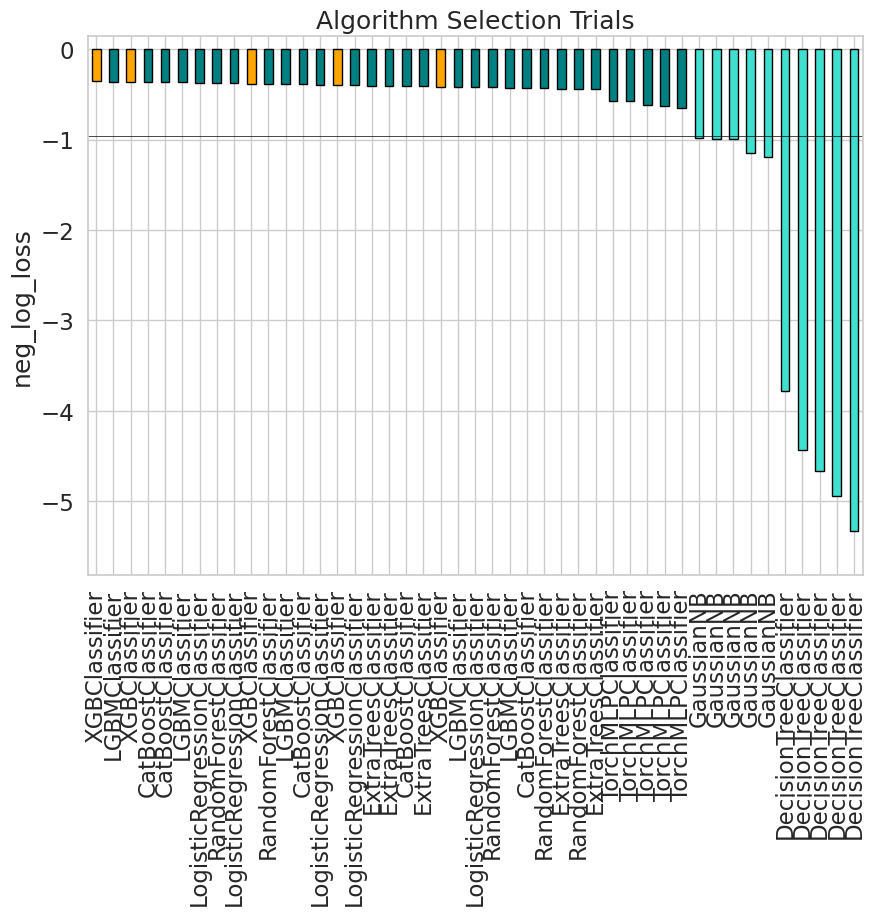

In [12]:
# Graph the results from the "Model Selection" step/stage
trials_raw = est1.completed_trials_detailed_
trials = trials_raw[trials_raw['Step'] == 'Model Selection']

colors = []
scores = trials['Score (neg_log_loss)'].tolist()
models = trials['Algorithm'].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)

for index, value in s.items():
    if index == est1.selected_model_:
        colors.append('orange')
    elif value >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')
        
fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel('neg_log_loss')
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()

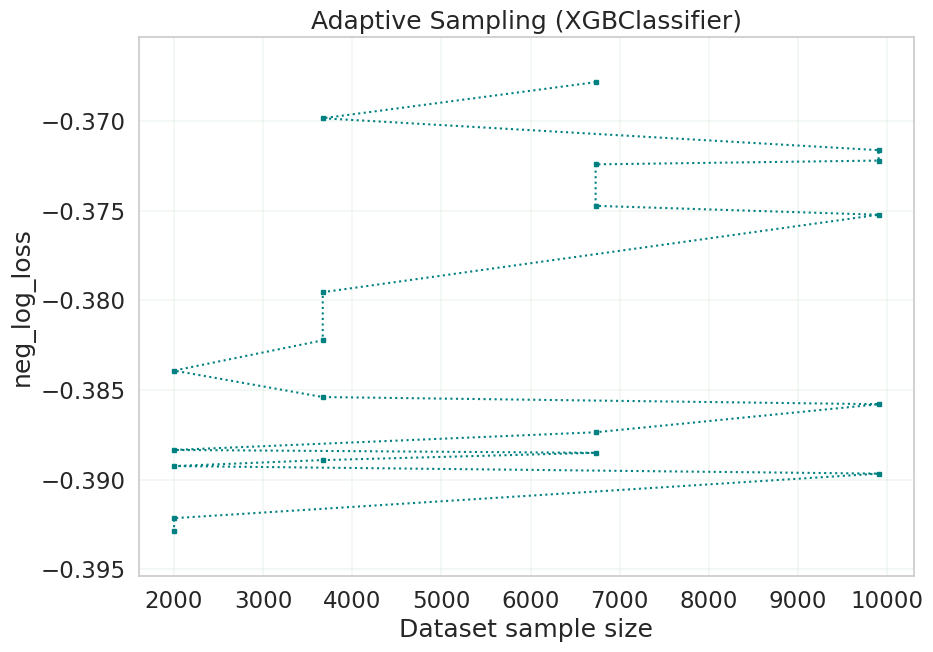

In [13]:
# Graph the results from the "Adaptive Sampling" step/stage
trials = trials_raw[trials_raw['Step'] == 'Adaptive Sampling']
trials = trials[trials['Score (neg_log_loss)'] != -np.inf ]

scores    = trials['Score (neg_log_loss)'].tolist()
models    = trials['Algorithm'].tolist()
n_samples = trials['# Samples'].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
        
fig, ax = plt.subplots(1)
ax.set_title("Adaptive Sampling ({})".format(models[0].removeprefix("AdaptiveSamplingStage_")))
ax.set_xlabel('Dataset sample size')
ax.set_ylabel('neg_log_loss')
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_samples, scores, 'k:', marker="s", color='teal', markersize=3)
plt.show()

Features selected: ['age', 'capitalgain', 'capitalloss', 'education', 'education-num', 'fnlwgt', 'hoursperweek', 'marital-status', 'native-country', 'occupation', 'race', 'relationship', 'sex_1', 'sex_2', 'workclass']
Features available: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']
Features dropped: Index(['sex'], dtype='object')


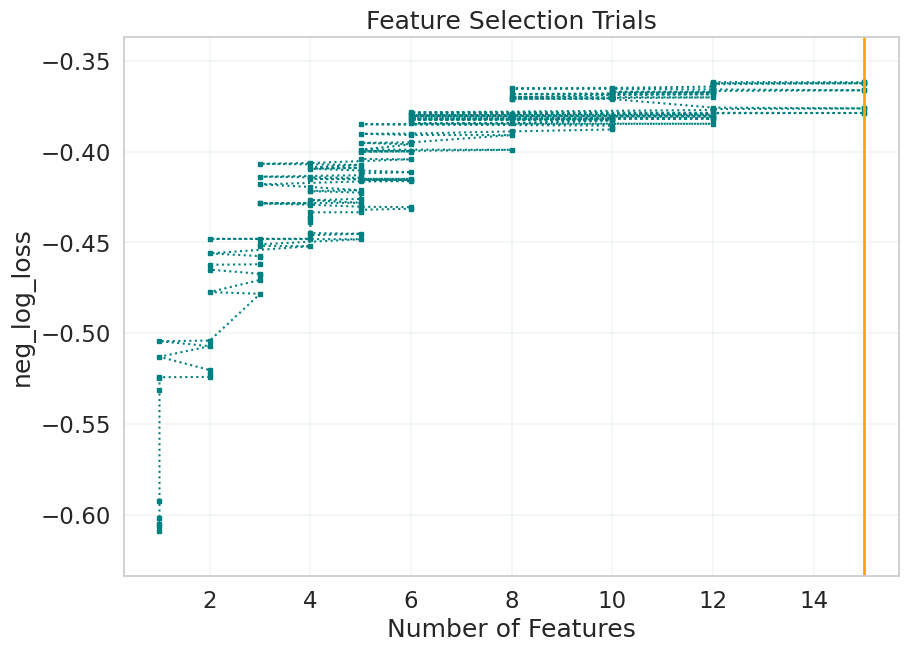

In [14]:
# Graph the results from the "Feature Selection" step/stage
print(f"Features selected: {est1.selected_features_names_}")
print(f"Features available: {df.keys().tolist()}")
dropped_features = df.keys().drop(est1.selected_features_names_, errors='ignore')
print(f"Features dropped: {dropped_features}") # <-- Need to take this output with a grain of salt as AutoMLX seemed to add "_#" indexes to ceratin feature names
 
trials = trials_raw[trials_raw['Step'] == 'Feature Selection']

scores    = trials['Score (neg_log_loss)'].tolist()
models    = trials['Algorithm'].tolist()
n_features = trials['# Features'].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
        
fig, ax = plt.subplots(1)
ax.set_title("Feature Selection Trials")
ax.set_xlabel('Number of Features')
ax.set_ylabel('neg_log_loss')
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_features, scores, 'k:', marker="s", color='teal', markersize=3)
ax.axvline(x=len(est1.selected_features_names_), color='orange', linewidth=2.0)
plt.show()

Text(83.25, 0.5, 'Actual')

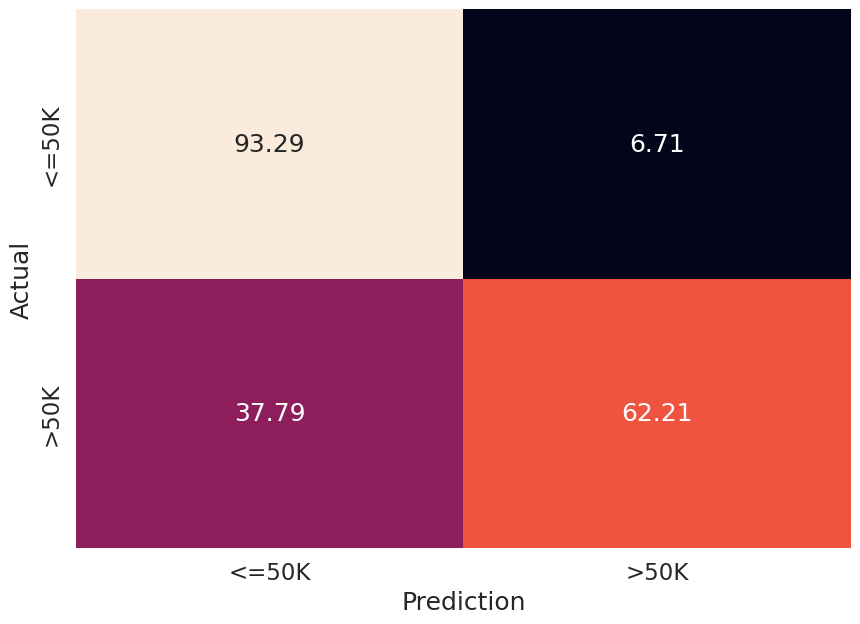

In [15]:
# Graphy the confusion matrix for our pipeline
y_pred = est1.predict(X_test)
cm = confusion_matrix(y_test.astype(int), y_pred, labels=[False, True])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm)
df_cm = df_cm * 100

ax = sns.heatmap(df_cm, annot=True, fmt='.2f', cbar=False, xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')

In [16]:
# Pipeline Variation - Provide a specific model list to AutoML
est2 = automlx.Pipeline(model_list=['LogisticRegression']) # Default task type is "classification"
est2.fit(X_train, y_train)
y_proba = est2.predict_proba(X_test)
score_modellist = roc_auc_score(y_test, y_proba[:, 1])

print(f'ROC AUC Score on test data: {score_modellist}') # Expect many warning as 'LogisticRegression' is not a good match for this data (does not converge in most cases)

[2025-10-28 13:15:30,556] [automlx.interface] Dataset shape: (34189,14)
[2025-10-28 13:15:30,647] [automlx.data_transform] Running preprocessing. Number of features: 15
[2025-10-28 13:15:31,270] [automlx.data_transform] Preprocessing completed. Took 0.623 secs
[2025-10-28 13:15:31,282] [automlx.process] Running Model Generation
[2025-10-28 13:15:31,331] [automlx.process] Model Generation completed.
[2025-10-28 13:15:31,354] [automlx.model_selection] Running Model Selection
[2025-10-28 13:15:31,354] [automlx.trials] Fewer models (1) than top_k (1) provided, skipping...
[2025-10-28 13:15:31,378] [automlx.adaptive_sampling] Running Adaptive Sampling. Dataset shape: (34189,16).
[2025-10-28 13:15:34,867] [automlx.trials] Adaptive Sampling completed - Took 3.4894 sec.
[2025-10-28 13:15:34,970] [automlx.feature_selection] Starting feature ranking for LogisticRegressionClassifier
[2025-10-28 13:16:18,659] [automlx.feature_selection] Feature Selection completed. Took 43.715 secs.
[2025-10-28 13

/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

[2025-10-28 13:18:05,407] [automlx.trials] Best parameters for LogisticRegressionClassifier: {'C': 47.00427550259388, 'solver': 'saga', 'class_weight': 'balanced'}
[2025-10-28 13:18:05,411] [automlx.trials] Model Tuning completed. Took: 106.719 secs
[2025-10-28 13:18:08,662] [automlx.interface] Re-fitting pipeline
[2025-10-28 13:18:08,675] [automlx.final_fit] Skipping updating parameter seed, already fixed by FinalFit_01a2bd67-1
[2025-10-28 13:18:11,278] [automlx.interface] AutoMLx completed.
ROC AUC Score on test data: 0.9030293274998966


In [17]:
# Pipeline Variation - Use a custom validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=0)

est3 = automlx.Pipeline()
est3.fit(X_train, y_train, X_val, y_val)

y_proba = est3.predict_proba(X_test)
score_modellist = roc_auc_score(y_test, y_proba[:, 1])

print(f'ROC AUC Score on test data: {score_modellist}')

[2025-10-28 13:18:12,083] [automlx.interface] Dataset shape: (34189,14)
[2025-10-28 13:18:12,254] [automlx.data_transform] Running preprocessing. Number of features: 15
[2025-10-28 13:18:13,111] [automlx.data_transform] Preprocessing completed. Took 0.858 secs
[2025-10-28 13:18:13,145] [automlx.process] Running Model Generation
[2025-10-28 13:18:13,206] [automlx.process] KNeighborsClassifier is disabled. The KNeighborsClassifier model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-10-28 13:18:13,209] [automlx.process] SVC is disabled. The SVC model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-10-28 13:18:13,212] [automlx.process] Model Generation completed.
[2025-10-28 13:18:13,332] [automlx.model_selection] Running Model Selection
[LightGBM] [Info] Number of positive: 2500, number of negative: 2500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008293 seconds.
You

/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 8 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 1 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 8 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 1 leaked folder objects to clean up at shutdown
  w

[2025-10-28 13:29:28,392] [automlx.trials] Best parameters for XGBClassifier: {'learning_rate': 0.100009999, 'min_child_weight': 1, 'max_depth': 4, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 13.719052934706653, 'n_estimators': 275, 'use_label_encoder': False}
[2025-10-28 13:29:28,394] [automlx.trials] Model Tuning completed. Took: 577.490 secs
[2025-10-28 13:29:29,855] [automlx.interface] Re-fitting pipeline
[2025-10-28 13:29:29,878] [automlx.final_fit] Skipping updating parameter seed, already fixed by FinalFit_3d4ed59b-4
[2025-10-28 13:29:39,012] [automlx.interface] AutoMLx completed.
ROC AUC Score on test data: 0.9143540425509908


In [18]:
# Pipeline Variation - Increase the number of tuned models
est4 = automlx.Pipeline(n_algos_tuned=2, model_list=['GaussianNB', 'LogisticRegression', 'XGBClassifier'])
est4.fit(X_train, y_train)

y_proba = est4.predict_proba(X_test)
score_modellist = roc_auc_score(y_test, y_proba[:, 1])

print(f'ROC AUC Score on test data: {score_modellist}')

[2025-10-28 13:29:39,929] [automlx.interface] Dataset shape: (23932,14)
[2025-10-28 13:29:40,019] [automlx.data_transform] Running preprocessing. Number of features: 15
[2025-10-28 13:29:40,511] [automlx.data_transform] Preprocessing completed. Took 0.492 secs
[2025-10-28 13:29:40,523] [automlx.process] Running Model Generation
[2025-10-28 13:29:40,572] [automlx.process] Model Generation completed.
[2025-10-28 13:29:40,601] [automlx.model_selection] Running Model Selection
[2025-10-28 13:29:45,130] [automlx.model_selection] Model Selection completed - Took 4.528 sec - Selected models: [['XGBClassifier', 'LogisticRegressionClassifier']]
[2025-10-28 13:29:45,172] [automlx.adaptive_sampling] Running Adaptive Sampling. Dataset shape: (23932,16).
[2025-10-28 13:29:57,928] [automlx.trials] Adaptive Sampling completed - Took 12.7561 sec.
[2025-10-28 13:29:58,040] [automlx.feature_selection] Starting feature ranking for XGBClassifier
[2025-10-28 13:31:53,473] [automlx.feature_selection] Featur

/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

[2025-10-28 13:48:44,418] [automlx.trials] Best parameters for LogisticRegressionClassifier: {'C': 47.004562925198094, 'solver': 'liblinear', 'class_weight': None}
[2025-10-28 13:48:44,420] [automlx.trials] Model Tuning completed. Took: 104.311 secs
[2025-10-28 13:48:54,221] [automlx.interface] Re-fitting pipeline
[2025-10-28 13:48:54,258] [automlx.final_fit] Skipping updating parameter seed, already fixed by FinalFit_bc746016-4
[2025-10-28 13:49:03,548] [automlx.interface] AutoMLx completed.
ROC AUC Score on test data: 0.9129618525298911


In [19]:
# Pipeline Variation - Specify a different scoring metric to AutoML
est5 = automlx.Pipeline(score_metric='accuracy', model_list=['XGBClassifier'])
est5.fit(X_train, y_train)

y_proba = est5.predict_proba(X_test)
score_modellist = roc_auc_score(y_test, y_proba[:, 1])

print(f'ROC AUC Score on test data: {score_modellist}')

[2025-10-28 13:49:04,819] [automlx.interface] Dataset shape: (23932,14)
[2025-10-28 13:49:04,984] [automlx.data_transform] Running preprocessing. Number of features: 15
[2025-10-28 13:49:05,473] [automlx.data_transform] Preprocessing completed. Took 0.489 secs
[2025-10-28 13:49:05,507] [automlx.process] Running Model Generation
[2025-10-28 13:49:05,556] [automlx.process] Model Generation completed.
[2025-10-28 13:49:05,625] [automlx.model_selection] Running Model Selection
[2025-10-28 13:49:05,625] [automlx.trials] Fewer models (1) than top_k (1) provided, skipping...
[2025-10-28 13:49:05,694] [automlx.adaptive_sampling] Running Adaptive Sampling. Dataset shape: (23932,16).
[2025-10-28 13:49:16,425] [automlx.trials] Adaptive Sampling completed - Took 10.7313 sec.
[2025-10-28 13:49:16,621] [automlx.feature_selection] Starting feature ranking for XGBClassifier
[2025-10-28 13:51:20,274] [automlx.feature_selection] Feature Selection completed. Took 123.678 secs.
[2025-10-28 13:51:20,345] [

/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 8 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 1 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 1 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py:314: UserWarning: resource_tracker: There appear to be 8 leaked semlock objects to clean up at shutdown
  w

[2025-10-28 13:59:23,366] [automlx.trials] Best parameters for XGBClassifier: {'learning_rate': 0.10038813027819354, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}
[2025-10-28 13:59:23,368] [automlx.trials] Model Tuning completed. Took: 483.023 secs
[2025-10-28 13:59:29,845] [automlx.interface] Re-fitting pipeline
[2025-10-28 13:59:29,863] [automlx.final_fit] Skipping updating parameter seed, already fixed by FinalFit_a416f87a-6
[2025-10-28 13:59:33,539] [automlx.interface] AutoMLx completed.
ROC AUC Score on test data: 0.9118680314219519


In [20]:
# Pipeline Variation - Specify a user defined scoring function to AutoML
#score_fn = make_scorer(f1_score, greater_is_better=True, needs_proba=False, average='macro')
def custom_mae_scorer(y_true, y_pred):
    """
    Custom Mean Absolute Error scorer.
    AutoMLx expects a function that takes (y_true, y_pred) as input.
    """
    def __init__(self, name="custom_mae_scorer"):
        self.__name__ = name
        self.y_true = y_true
        self.y_pred = y_pred
    
    return -mean_absolute_error(y_true, y_pred) # Return negative for optimization (AutoMLx maximizes scores)

est6 = automlx.Pipeline(
    task='classification',
    score_metric=custom_mae_scorer, # Or custom_mae_scorer if not using make_scorer
    random_state=42
)
est6.fit(X_train, y_train)

y_proba = est6.predict_proba(X_test)
score_modellist = roc_auc_score(y_test, y_proba[:, 1])

print(f'ROC AUC Score on test data: {score_modellist}')

[2025-10-28 13:59:34,864] [automlx.interface] Dataset shape: (23932,14)
[2025-10-28 13:59:34,951] [automlx.data_transform] Running preprocessing. Number of features: 15
[2025-10-28 13:59:35,506] [automlx.data_transform] Preprocessing completed. Took 0.554 secs
[2025-10-28 13:59:35,518] [automlx.process] Running Model Generation
[2025-10-28 13:59:35,575] [automlx.process] KNeighborsClassifier is disabled. The KNeighborsClassifier model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-10-28 13:59:35,578] [automlx.process] SVC is disabled. The SVC model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-10-28 13:59:35,580] [automlx.process] Model Generation completed.
[2025-10-28 13:59:35,667] [automlx.model_selection] Running Model Selection
[LightGBM] [Info] Number of positive: 2000, number of negative: 2000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You

In [ ]:
# Pipeline Variation - Specify a time budget to AutoML
est7 = automlx.Pipeline()
est7.fit(X_train, y_train, time_budget=10) # <-- This made an amazing difference in auto-modeling time, but did not change the score substantially

y_proba = est7.predict_proba(X_test)
score_modellist = roc_auc_score(y_test, y_proba[:, 1])

print(f'ROC AUC Score on test data: {score_modellist}')

In [ ]:
# Pipeline Variation - Specify a time budget to AutoML
est8 = automlx.Pipeline(min_features=['fnlwgt', 'native-country'], model_list=['XGBClassifier'])
est8.fit(X_train, y_train)

y_proba = est8.predict_proba(X_test)
score_modellist = roc_auc_score(y_test, y_proba[:, 1])

print(f'ROC AUC Score on test data: {score_modellist}')
print(f'Selected features: {est8.selected_features_names_}')